In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

第一步，先对数据集进行验证，验证它类型、维度、长度是否正确
然后我们需要初始化质点中心：这里有两种方法可以选择，分别是随机的还有先选一个随机的再取离那个随机的最远的点（k-means++）
接着我们需要开始迭代，计算每个点到各质点的欧式距离，然后选择最近的分配标签
欧式距离公式：
$$
\text{distance}(x, \mu) = \sqrt{\sum_{j=1}^{d} (x_j - \mu_j)^2}
$$
在计算距离的时候，我们先要沿最后一个维度，即特征维度求和，然后找沿质心维度的最小值的索引,最后更新质点

In [15]:
class Kmeans:
    def __init__(self,n_clusters=3,max_iter=1000,tol=1e-4):
        """
        初始化k-means的操作
        :param n_clusters: 簇个数
        :param max_iter: 迭代次数
        """
        self.n_clusters=n_clusters
        self.max_iter=max_iter
        self.tol=tol
        self.centroids=None
        self.labels=None

    def vali_data(self,x):
        """
        判断传入的数据集是否是二维数组，样本量是否足够，如果异常的话会给出提示
        :param x: 数据集
        :return:提示或者不返回 
        """
        if not isinstance(x,np.ndarray):
            raise TypeError('x must be numpy.ndarray')
        if len(x.shape)!=2:
            raise ValueError('x must be a 2-dimensional numpy.ndarray')
        if x.shape[0]<self.n_clusters:
            raise ValueError('x must have at least n_clusters')
    def initialize_centroids(self,x,method=None):
        """
        为两种不同方法统一接口
        :param x: 数据集
        :param method: 初始化质心的方法
        :return: 方法
        """
        self.vali_data(x)
        if method=="kmeans":
            return self.kmeans_centroids_init(x)
        elif method=="kmeans++":
            return self.kmeans_plus_centroids_init(x)
        else:
            raise ValueError("method must be 'kmeans' or 'kmeans++',please check your input")
    def kmeans_centroids_init(self,x):
        """
        用k-means方法初始化质心
        :param x:数据集
        """
        indices=np.random.choice(x.shape[0],self.n_clusters,replace=False)
        return x[indices]
    def kmeans_plus_centroids_init(self,x):
        """
        用k-means++方法初始化质心
        :param x:数据集
        """
        centroids=[x[np.random.choice(x.shape[0])]]
        for i in range(1, self.n_clusters):
            distances=np.array([min([np.sum(point-c)**2 for c in centroids])  for point in x])
            probabilities=distances/distances.sum()
            next_centroid=np.random.choice(x.shape[0],p=probabilities)
            centroids.append(x[next_centroid])
        return np.array(centroids)
    def fit(self,x):
        self.centroids=self.initialize_centroids(x,method="kmeans")
        for _ in range(self.max_iter):
            distances=np.sqrt(((x[:,np.newaxis]-self.centroids)**2).sum(axis=2))
            self.labels=np.argmin(distances,axis=1)
            new_centroids=np.array([x[self.labels==i].mean(axis=0)
                                    for i in range(self.n_clusters)])
            if np.all(np.abs(new_centroids-self.centroids)<self.tol):
                break
            self.centroids=new_centroids
    def predict(self, x):
        if self.centroids is None:
            raise ValueError("模型尚未训练，请先调用fit方法")
        distances=np.sqrt(((x[:, np.newaxis]-self.centroids)**2).sum(axis=2))
        return np.argmin(distances, axis=1)

In [17]:
path="data.csv"
data=pd.read_csv(path)
print(data.head())
x=data.iloc[:,:-1].values
y=data.iloc[:,-1].values
if y.dtype==object:
    y_label=pd.factorize(y)[0]
print(data.isnull().sum())

   SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
0            5.1           3.5            1.4           0.2  Iris-setosa
1            4.9           3.0            1.4           0.2  Iris-setosa
2            4.7           3.2            1.3           0.2  Iris-setosa
3            4.6           3.1            1.5           0.2  Iris-setosa
4            5.0           3.6            1.4           0.2  Iris-setosa
SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64


数据集中没有缺失值，所以在处理数据的时候不用处理缺失值了。接下来对数据集进行特征归一化
Z-score标准化

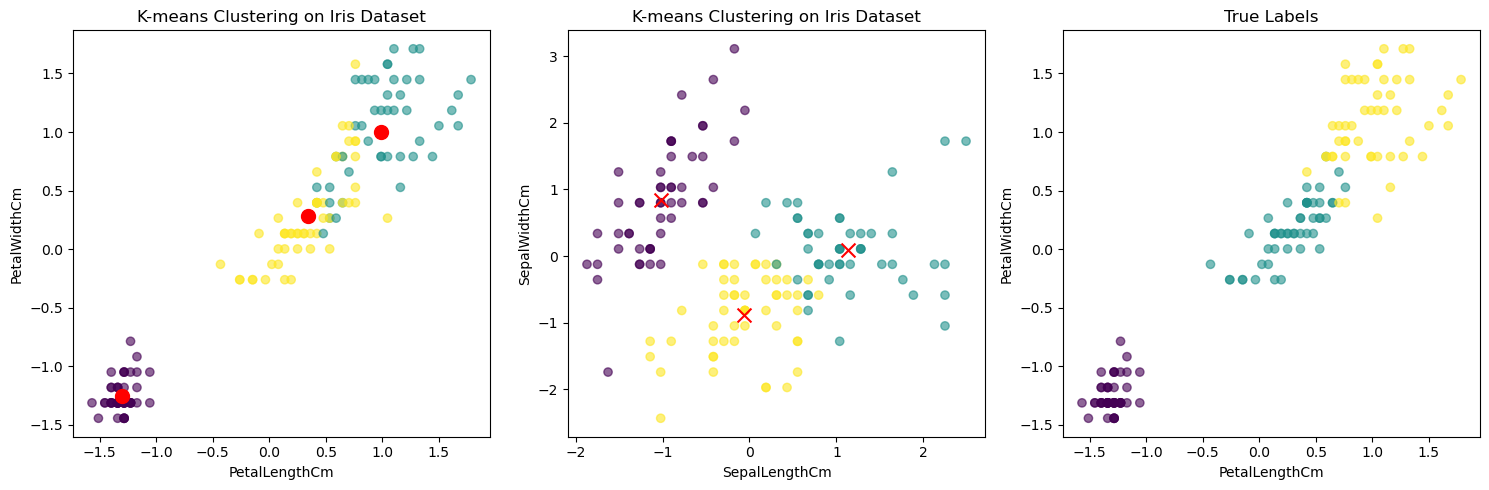

In [20]:
def standardize(x):
    mean=np.mean(x,axis=0)
    std=np.std(x,axis=0)
    x_standardized=(x-mean)/std
    return x_standardized

x_standardized=standardize(x)
kmeans=Kmeans(n_clusters=3,max_iter=1000,tol=1e-4)
kmeans.fit(x_standardized)
labels=kmeans.predict(x_standardized)
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.scatter(x_standardized[:,2],x_standardized[:,3],c=labels,cmap='viridis',alpha=0.6)
plt.scatter(kmeans.centroids[:,2],kmeans.centroids[:,3],marker="o",s=100,c="red")
plt.xlabel("PetalLengthCm")
plt.ylabel("PetalWidthCm")
plt.title("K-means Clustering on Iris Dataset")
plt.subplot(132)
plt.scatter(x_standardized[:, 0],x_standardized[:, 1],c=labels,cmap='viridis',alpha=0.6)
plt.scatter(kmeans.centroids[:,0],kmeans.centroids[:,1],marker='x',s=100,c='red')
plt.xlabel("SepalLengthCm")
plt.ylabel("SepalWidthCm")
plt.title("K-means Clustering on Iris Dataset")

plt.subplot(133)
plt.scatter(x_standardized[:,2],x_standardized[:,3],c=y_label,cmap='viridis',alpha=0.6)
plt.xlabel("PetalLengthCm")
plt.ylabel("PetalWidthCm")
plt.title("True Labels")
plt.tight_layout()
plt.show()

这里可以通过观察看出来，选择"PetalLengthCm""PetalWidthCm"来做这个更好